In [31]:
import csv
import matplotlib
import matplotlib.pyplot as plt
import string
import math

import numpy as np

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)

from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import nltk

In [2]:
print("Reading data..." )    
        
with open('questions.csv') as csvfile:
    reader = csv.reader(csvfile)
    keys = next(reader)
    data = [row for row in reader]  
    
print("done")

Reading data...
done


In [3]:
def vectorize_string(s):
    '''
    turns a string into a dictionary of words. 
    Can be used as a 'vector' where noexistant keys have val 0
    
    Each (substrings of len p) maps to the amount of appearances
    of itself in the original string
    '''
    
    v = {}
    for word in s.split():
        if word in v:
            v[word] += 1
        else:
            v[word] = 1
            
    return v

#indexes for values in data
pid = 0
qid1 = 1
qid2 = 2
q1 = 3
q2 = 4
dup = 5

punctuation = set(string.punctuation)
for d in data:
    d[q1] = ''.join([c for c in d[q1].lower() if not c in punctuation])
    d[q2] = ''.join([c for c in d[q2].lower() if not c in punctuation])


uniq_questions = {} # list of unique questions strings

for d in data:
    if d[q1] in uniq_questions:
        uniq_questions[d[q1]] += 1
    else:
        uniq_questions[d[q1]] = 1
    
    if d[q2] in uniq_questions:
        uniq_questions[d[q2]] += 1
    else:
        uniq_questions[d[q2]] = 1
        
'''
Uses all unique questions as set of documents
idf = log10(document count / document count for word)
'''
gidf = {}
for q in uniq_questions:
    d = vectorize_string(q)
    for word in d:
        if word in gidf:
            gidf[word] += 1
        else:
            gidf[word] = 1

for word in gidf:
    gidf[word] = math.log10(len(uniq_questions)/gidf[word])

In [4]:
# transform data into useable formats
# [int,int,int,dict,dict,int]

for i in range(len(data)):
    data[i][pid] = int(data[i][pid])
    data[i][qid1] = int(data[i][qid1])
    data[i][qid2] = int(data[i][qid2])
    data[i][q1] = vectorize_string(data[i][q1])
    data[i][q2] = vectorize_string(data[i][q2])
    data[i][dup] = int(data[i][dup])

In [5]:
def magnitude_dict(data):
    '''
    Evaulats the magnitude of a dict
    '''
    
    return sum([value**2 for value in data.values()])**.5


def dot_dicts(d1,d2):
    '''
    multiplies the values of the overlaping keys
    in two dictionaries.  It chooses to iterate
    over the smaller and lookup in the larger
    '''
    
    a = d1 if len(d1) < len(d2) else d2
    b = d2 if len(d1) < len(d2) else d1
    
    dot = 0
    # a is shorter than b
    for s in a:
        if s in b:
            dot += a[s]*b[s]
            
    return dot
    
    
def cosine_simularity_dicts(d1,d2):
    '''
    returns the cosine simularity of two strings
    words in each string are considered dimensions
    '''

    if (len(d1) == 0 and len(d2) == 0):
        return 1
    elif (len(d1) == 0 or len(d2) == 0):
        return 0

    return dot_dicts(d1,d2)/(magnitude_dict(d1)*magnitude_dict(d2))


def intersect_dicts(d1,d2):
    '''
    returns an integer count of the intesecting keys in 
    two dictionaries
    '''
    
    a = d1 if len(d1) < len(d2) else d2
    b = d2 if len(d1) < len(d2) else d1
    
    count = 0
    for s in a:
        if s in b:
            count += 1
            
    return count


def union_dicts(d1,d2):
    '''
    returns an integer count of the union of keys in 
    two dictionaries
    '''
    
    shared = 0
    unique = 0
    
    for s in d1:
        if s in d2:
            shared += 1
        else:
            unique += 1
    
    for s in d2:
        if s not in d1:
            unique += 1
            
    return shared + unique 

    
def jaccard_simularity_dicts(d1,d2):
    '''
    returns the jaccard simularity of two strings
    words in each strings are considered dimensions
    '''
    
    if (len(d1) == 0 and len(d2) == 0):
        return 1
    elif (len(d1) == 0 or len(d2) == 0):
        return 0

    return float(intersect_dicts(d1,d2))/union_dicts(d1,d2)


def sum_tf_idf(d1,d2):
    '''
    returns the sum of the tf-idf of each word in two dicts
    '''
    
    idf = {}
    for word in d1:
        if word in d1 and word in d2:
            idf[word] = 0
        else:
            idf[word] = 0.3010299956639812 # hard coded log10(2)
    for word in d2:
        if word not in idf:
            idf[word] = 0.3010299956639812
    
    tf_idf = {}
    for word in d1:
        tf_idf[word] = float(d1[word])/len(d1)*idf[word]
    for word in d2:
        if word not in tf_idf:
            tf_idf[word] = float(d2[word])/len(d2)*idf[word]
            
    total = 0
    for word in tf_idf:
        total += tf_idf[word]
        
    return total


def sum_tf_gidf(d1,d2):
    tf_gidf = {}
    for word in d1:
        tf_gidf[word] = float(d1[word])/len(d1)*gidf[word]
    for word in d2:
        if word not in tf_gidf:
            tf_gidf[word] = float(d2[word])/len(d2)*gidf[word]
            
    total = 0
    for word in tf_gidf:
        total += tf_gidf[word]
        
    return total


def sum_tf_idf_gidf(d1,d2):
    '''
    returns the sum of the tf-idf of each word in
    both strings
    '''
    
    idf = {}
    for word in d1:
        if word in d1 and word in d2:
            idf[word] = 0
        else:
            idf[word] = 0.3010299956639812
    for word in d2:
        if word not in idf:
            idf[word] = 0.3010299956639812
    
    tf_idf = {}
    for word in d1:
        tf_idf[word] = float(d1[word])/len(d1)*idf[word]*gidf[word]
    for word in d2:
        if word not in tf_idf:
            tf_idf[word] = float(d2[word])/len(d2)*idf[word]*gidf[word]
            
    total = 0
    for word in tf_idf:
        total += tf_idf[word]
        
    return total


def char_count_dict(d1):
    '''
    counts the charcters of all the words, words are
    scaled with their counds
    '''
    
    count = 0
    for word in d1:
        count += len(word)*d1[word]
        
    return count

In [58]:
def lem_jac_dicts(d1,d2):
    '''
    returns a list of the jaccard simularities of parts of speech
    of the words in two dictionaries
    '''
    tagged_d1 = nltk.pos_tag(d1.keys())
    tagged_d2 = nltk.pos_tag(d2.keys())
    
    parts = ['JJ', 'NN', 'VB']
    
    jaccards = []
    
    for part in parts:
        filtered_d1 = {word:d1[word] for (word,tag) in tagged_d1 if part in tag}
        filtered_d2 = {word:d2[word] for (word,tag) in tagged_d2 if part in tag}
#         print(filtered_d1)
#         print(filtered_d2)
        jaccards.append(jaccard_simularity_dicts(filtered_d1, filtered_d2))
    
    return jaccards
    

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [75]:
def feature_vector(point):
    d1 = point[q1]
    d2 = point[q2]
    
    v = [ 
        len(d1),
        len(d2),
#        len(d1)-len(d2),
#         char_count_dict(d1),
#         char_count_dict(d2),
#         dot_dicts(d1,d2),
        union_dicts(d1,d2),
        intersect_dicts(d1,d2),
        cosine_simularity_dicts(d1,d2),
        jaccard_simularity_dicts(d1,d2),
        sum_tf_idf(d1,d2),
        sum_tf_gidf(d1,d2),
        sum_tf_idf_gidf(d1,d2),
    ] + lem_jac_dicts(d1,d2)

    
    return v

X = [feature_vector(d) for d in data]
y = [d[dup] for d in data]

In [80]:
# 250k training
X_train = X[:20000]
y_train = y[:20000]

# 100k validate
X_valid = X[250000:350000]
y_valid = y[250000:350000]

# 54351 test
X_test = X[350000:]
y_test = y[350000:]

In [81]:
type(X_train[0])

list

In [82]:
clf = {}
clf_score = {}
for i in range(-2,3):
    C = 10**i
    clf[C] = svm.SVC(C=C)
    clf[C].fit(X_train, y_train)

    train_predictions = clf[C].predict(X_train)
    test_accuracy = accuracy_score(y_train,train_predictions)
    valid_predictions = clf[C].predict(X_valid)
    valid_accuracy = accuracy_score(y_valid,valid_predictions)
    
    clf_score[C] = valid_accuracy
    
    print('|',C, '|', test_accuracy, '|', valid_accuracy, '|')
    

| 0.01 | 0.6713 | 0.6743 |
| 0.1 | 0.7031 | 0.70177 |
| 1 | 0.7241 | 0.71474 |
| 10 | 0.7503 | 0.71827 |
| 100 | 0.7867 | 0.7122 |


Best Classifier Data

uses C = 10.00

             precision    recall  f1-score   support

          0       0.78      0.75      0.77     62962
          1       0.61      0.64      0.62     37038

avg / total       0.72      0.71      0.71    100000

Accuracy: 0.7122

Normalized confusion matrix
[[ 0.75482037  0.24517963]
 [ 0.36025163  0.63974837]]


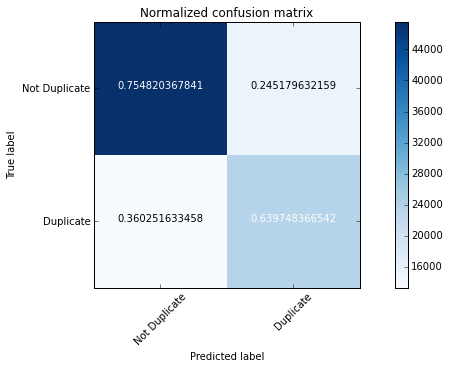

In [83]:
best_C = 0.01
for C in clf_score:
    if clf_score[C] > clf_score[best_C]:
        best_C = C
print('Best Classifier Data\n')
print('uses C = %.2f\n'%best_C)
best_valid_predictions = clf[C].predict(X_valid)
        
print(classification_report(y_valid, best_valid_predictions))
print('Accuracy:', accuracy_score(y_valid, best_valid_predictions))
print()
cm = confusion_matrix(y_valid, best_valid_predictions)
class_names = ['Not Duplicate', 'Duplicate']
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')

# Baseline, 5k
|C|accuracy(train)|accuracy(valid)|
|---|---|---|
| 0.01 | 0.6176 | 0.62962 |
| 0.1 | 0.6946 | 0.68354 |
| 1 | 0.7248 | 0.69742 |
| 10 | 0.7604 | 0.69599 |
| 100 | 0.7978 | 0.6855 |

# train = 20k
|C|accuracy(train)|accuracy(valid)|
|---|---|---|
| 0.01 | 0.6673 | 0.67076 |
| 0.1 | 0.7019 | 0.70092 |
| 1 | 0.72145 | 0.714 |
| 10 | 0.74245 | 0.71644 |
| 100 | 0.7637 | 0.71248 |


# train = 10k
|C|accuracy(train)|accuracy(valid)|
|---|---|---|
| 0.01 | 0.6598 | 0.65762 |
| 0.1 | 0.6978 | 0.69328 |
| 1 | 0.7185 | 0.70849 |
| 10 | 0.7494 | 0.71066 |
| 100 | 0.7815 | 0.70182 |
# train = 5k
|C|accuracy(train)|accuracy(valid)|
|---|---|---|
| 0.01 | 0.6176 | 0.62962 |
| 0.1 | 0.6946 | 0.68354 |
| 1 | 0.7248 | 0.69742 |
| 10 | 0.7604 | 0.69599 |
| 100 | 0.7978 | 0.6855 |
# train = 1k
|C|accuracy(train)|accuracy(valid)|
|---|---|---|
| 0.01 | 0.62 | 0.62962 |
| 0.1 | 0.682 | 0.66529 |
| 1 | 0.746 | 0.68287 |
| 10 | 0.828 | 0.66551 |
| 100 | 0.897 | 0.64934 |